## This is where I do all of my verification

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from datetime import datetime, timedelta
import cmocean

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow.python.keras.optimizer_v2.adam import Adam
tfd = tfp.distributions
import tensorflow.keras.backend as K
from tensorflow import math as tfm

import os

import utilsProb
import utilsProbSS
import glob
import sys
from scipy.stats import rankdata
import pandas as pd
import importlib
import copy
from netCDF4 import Dataset, num2date
from scipy.interpolate import interpn
from matplotlib.colors import Normalize 
from matplotlib import cm
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context("paper")
import properscoring as ps
from math import erf
import xarray as xr

import matplotlib
#mapping
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import Unet_b
import utils_CNN
from tensorflow.python.client import device_lib
import xarray as xr

import coms
import utilsAnEn
import utils_verif
import comsnn
from sklearn.metrics import brier_score_loss
from tqdm import tqdm


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Resolution & reliability 

## Define my color pallete

In [3]:
mycolors = {'$GEFS_{nn}$':[0.7561707035755478, 0.21038062283737025, 0.22352941176470587], 
            '$MV_gefs$':[0.940715109573241, 0.6099192618223759, 0.4812764321414839],
            '$GEFS$':[0.9838523644752019, 0.8089965397923875, 0.7167243367935409],
            '$CNN$':[1,1,1],
            '$CNNft_ref$': [1,1,1],
            '$NN$': [0.530026912725875, 0.7456362937331797, 0.8560553633217994],
            '$AnEn$': [0.1843137254901961, 0.47266435986159167, 0.7116493656286044],
            '$FCN$': [0.0196078431372549, 0.18823529411764706, 0.3803921568627451]}


SScolors = {'$GEFS_{nn}$':[0.7561707035755478, 0.21038062283737025, 0.22352941176470587], 
            '$MV_gefs$':[0.940715109573241, 0.6099192618223759, 0.4812764321414839],
            '$GEFS$':[0.9838523644752019, 0.8089965397923875, 0.7167243367935409],
            '$CNN$':[0,0,0],
            '$CNNft_ref$': [0,0,0],
            '$NN$': [0.530026912725875, 0.7456362937331797, 0.8560553633217994],
            '$AnEn$': [0.1843137254901961, 0.47266435986159167, 0.7116493656286044],
            '$FCN$': [0.0196078431372549, 0.18823529411764706, 0.3803921568627451]}

#boxplot dict
BPdict = {'tickFS':30,'labelFS':35,'titleFS':35,'legendFS':25,'FigSize':np.array([40,10])}

#spread/skill dict
SSdict = {'tickFS':25,'labelFS':25,'titleFS':35,'legendFS':25,'FigSize':np.array([15,10])}

#RankHist dict
RHdict = {'tickFS':25,'labelFS':25,'titleFS':35,'legendFS':25,'FigSize':np.array([20, 6])}

## Make the Brier Data Frames:

In [4]:
percys = [250,350,500]

for percy in percys:
    dffin=pd.DataFrame({'Lead':[],'Model':[],'CRPS':[]})
    fcasts = ['F'+f'{bb:03}' for bb in np.arange(0,126,12)]
    bsnummy = 1000
    df1, df2, dfm = 1,1,1

    for fcast in fcasts:
        print('doing:',fcast)
        ########################################################################################################
        fortts=np.array([])
        mods = ['CNNft_ref','MV_gefs','Raw_gefs','AnEn','NNft_ref']
        for mod in mods:
            df,Pre_m, Pre_s, Post_m, Post_s, Obs =utils_verif.load_forecast(fcast,mod)
            fortts=np.concatenate([fortts,np.array(Post_m)])
            bounds =[]
            threshold = percy
        ##############
        print("this is the threshold:",threshold,'for a percentile:', percy)
        ########################################################################################################
        del df1
        del df2
        del dfm
        mod = 'Raw_gefs'
        df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df1 = df1.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})

        mod = 'NN_gefs'
        df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df2 = df2.rename(columns={'OBS':'OBScnn','Model':'Reforecast','IVTmean':'IVTmean_cnn','IVTstd':'IVTstd_cnn'})

        dfm = pd.merge(df1,df2,how='left')

        bp_nn = np.zeros([bsnummy])
        cor_nn= np.zeros([bsnummy])
        bres_nn = np.zeros([bsnummy])
        brel_nn = np.zeros([bsnummy])
        bs2_nn = np.zeros([bsnummy])
        bs3_nn= np.zeros([bsnummy])
        
        
        bp_nng = np.zeros([bsnummy])
        cor_nng= np.zeros([bsnummy])
        bres_nng = np.zeros([bsnummy])
        brel_nng = np.zeros([bsnummy])
        bs2_nng = np.zeros([bsnummy])
        bs3_nng= np.zeros([bsnummy])
        for aa in range(bsnummy):
            inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])        
            ff = np.stack([dfm['IVTmean_gefs'][inss],dfm['IVTstd_gefs'][inss]]).T
            probs_forg = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_forg = (np.array(dfm['OBSnn'][inss])>=threshold)*1
        
            ff = np.stack([dfm['IVTmean_cnn'][inss],dfm['IVTstd_cnn'][inss]]).T
            probs_for = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_for = (np.array(dfm['OBScnn'][inss])>=threshold)*1

            bp_nn[aa] = brier_score_loss(verif_for, probs_for)
            bres_nn[aa] = utils_verif.brier_decompose(verif_for, probs_for)[1]
            brel_nn[aa] = utils_verif.brier_decompose(verif_for, probs_for)[2]
            bs2_nn[aa]  = utils_verif.brier_decompose(verif_for, probs_for)[0]
            bs3_nn[aa]  = utils_verif.brier_decompose(verif_for, probs_for)[4]
            
            bp_nng[aa] = brier_score_loss(verif_forg, probs_forg)
            bres_nng[aa] = utils_verif.brier_decompose(verif_forg, probs_forg)[1]
            brel_nng[aa] = utils_verif.brier_decompose(verif_forg, probs_forg)[2]
            bs2_nng[aa]  = utils_verif.brier_decompose(verif_forg, probs_forg)[0]
            bs3_nng[aa]  = utils_verif.brier_decompose(verif_forg, probs_forg)[4]
    
        dftemp = pd.DataFrame({'Brier':bp_nn})
        dftemp['Lead'] = fcast
        dftemp['Res'] = bres_nn
        dftemp['Rel'] = brel_nn
        dftemp['Brier2'] = bs2_nn
        dftemp['Brier3'] = bs3_nn
        dftemp['Model'] = '$GEFS_{nn}$'
        dffin = pd.concat([dffin, dftemp], axis=0)
        
        
        dftemp = pd.DataFrame({'Brier':bp_nng})
        dftemp['Lead'] = fcast
        dftemp['Res'] = bres_nng
        dftemp['Rel'] = brel_nng
        dftemp['Brier2'] = bs2_nng
        dftemp['Brier3'] = bs3_nng
        dftemp['Model'] = '$GEFS$'
        dffin = pd.concat([dffin, dftemp], axis=0)
    
        ########################################################################################################

        del df1
        del df2
        del dfm
    
        mod = 'Raw_gefs'
        df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df1 = df1.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})

        mod = 'CNN_ref'
        df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df2 = df2.rename(columns={'OBS':'OBScnn','Model':'Reforecast','IVTmean':'IVTmean_cnn','IVTstd':'IVTstd_cnn'})
        df2['lon']=df2['lon']+360

        dfm = pd.merge(df1,df2,how='left')

        bp_cnn = np.zeros([bsnummy])
        cor_cnn= np.zeros([bsnummy])
        bres_cnn = np.zeros([bsnummy])
        brel_cnn = np.zeros([bsnummy])
        bs2_cnn = np.zeros([bsnummy])
        bs3_cnn= np.zeros([bsnummy])
        for aa in range(bsnummy):
            inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])        
            ff = np.stack([dfm['IVTmean_gefs'][inss],dfm['IVTstd_gefs'][inss]]).T
            probs_forg = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_forg = (np.array(dfm['OBSnn'][inss])>=threshold)*1
        
            ff = np.stack([dfm['IVTmean_cnn'][inss],dfm['IVTstd_cnn'][inss]]).T
            probs_for = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_for = (np.array(dfm['OBScnn'][inss])>=threshold)*1

            bp_cnn[aa] = brier_score_loss(verif_for, probs_for)
            bres_cnn[aa] = utils_verif.brier_decompose(verif_for, probs_for)[1]
            brel_cnn[aa] = utils_verif.brier_decompose(verif_for, probs_for)[2]
            bs2_cnn[aa]  = utils_verif.brier_decompose(verif_for, probs_for)[0]
            bs3_cnn[aa]  = utils_verif.brier_decompose(verif_for, probs_for)[4]
    
        dftemp = pd.DataFrame({'Brier':bp_cnn})
        dftemp['Lead'] = fcast
        dftemp['Model'] = '$CNN$'
        dftemp['Res'] = bres_cnn
        dftemp['Rel'] = brel_cnn
        dftemp['Brier2'] = bs2_cnn
        dftemp['Brier3'] = bs3_cnn
        dffin = pd.concat([dffin, dftemp], axis=0)
        
        ########################################################################################################
        del df1
        del df2
        del dfm
        mod = 'Raw_gefs'
        df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df1 = df1.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})

        mod = 'NNft_ref'
        df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df2 = df2.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_nn','IVTstd':'IVTstd_nn'})
        df2['lon']=df2['lon']+360

        dfm = pd.merge(df1,df2,how='left')

        bp_nn = np.zeros([bsnummy])
        cor_nn = np.zeros([bsnummy])
        bres_nn = np.zeros([bsnummy])
        brel_nn = np.zeros([bsnummy])
        bs2_nn = np.zeros([bsnummy])
        bs3_nn= np.zeros([bsnummy])
        for aa in range(bsnummy):
            inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])        
            ff = np.stack([dfm['IVTmean_gefs'][inss],dfm['IVTstd_gefs'][inss]]).T
            probs_forg = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_forg = (np.array(dfm['OBSnn'][inss])>=threshold)*1
            
            ff = np.stack([dfm['IVTmean_nn'][inss],dfm['IVTstd_nn'][inss]]).T
            probs_for = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_for = (np.array(dfm['OBSnn'][inss])>=threshold)*1

            bp_nn[aa] = brier_score_loss(verif_for, probs_for)
            
            bres_nn[aa] = utils_verif.brier_decompose(verif_for, probs_for)[1]
            brel_nn[aa] = utils_verif.brier_decompose(verif_for, probs_for)[2]
            bs2_nn[aa]  = utils_verif.brier_decompose(verif_for, probs_for)[0]
            bs3_nn[aa]  = utils_verif.brier_decompose(verif_for, probs_for)[4]

        dftemp = pd.DataFrame({'Brier':bp_nn})
        dftemp['Lead'] = fcast
        dftemp['Model'] = '$NN$'
        dftemp['Res'] = bres_nn
        dftemp['Rel'] = brel_nn
        dftemp['Brier2'] = bs2_nn
        dftemp['Brier3'] = bs3_nn
        dffin = pd.concat([dffin, dftemp], axis=0)
    
    
    
        ########################################################################################################
        del df1
        del df2
        del dfm
        mod = 'Raw_gefs'
        df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df1 = df1.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})

        mod = 'AnEn'
        df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df2 = df2.rename(columns={'OBS':'OBSanen','Model':'Reforecast','IVTmean':'IVTmean_nn','IVTstd':'IVTstd_nn'})
        df2['Mean'] = np.mean(df2.filter(regex='Analog'),axis=1)
        df2['std'] = np.std(df2.filter(regex='Analog'),axis=1)
        df2['time']= df2['Issued_Time']+ timedelta(hours=int(fcast[-3:]))

        dfm = pd.merge(df1,df2,how='left')
    
        bp_anen = np.zeros([bsnummy])
        corr_anen = np.zeros([bsnummy])
        bres_anen = np.zeros([bsnummy])
        brel_anen = np.zeros([bsnummy])
        bs2_anen = np.zeros([bsnummy])
        bs3_anen = np.zeros([bsnummy])
        for aa in range(bsnummy):
            inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])        
            ff = np.stack([dfm['IVTmean_gefs'][inss],dfm['IVTstd_gefs'][inss]]).T
            probs_forg = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_forg = (np.array(dfm['OBSnn'][inss])>=threshold)*1
        
            ff = np.stack([dfm['Mean'][inss],dfm['std'][inss]]).T
            probs_for = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_for = (np.array(dfm['OBSanen'][inss])>=threshold)*1

            bp_anen[aa] = brier_score_loss(verif_for, probs_for)
            bres_anen[aa] = utils_verif.brier_decompose(verif_for, probs_for)[1]
            brel_anen[aa] = utils_verif.brier_decompose(verif_for, probs_for)[2]
            bs2_anen[aa]  = utils_verif.brier_decompose(verif_for, probs_for)[0]
            bs3_anen[aa]  = utils_verif.brier_decompose(verif_for, probs_for)[4]
              
    
        dftemp = pd.DataFrame({'Brier':bp_anen})
        dftemp['Lead'] = fcast
        dftemp['Model'] = '$AnEn$'
        dftemp['Res'] = bres_anen
        dftemp['Rel'] = brel_anen
        dftemp['Brier2'] = bs2_anen
        dftemp['Brier3'] = bs3_anen
        dffin = pd.concat([dffin, dftemp], axis=0)
        print(dffin.shape)
        
        
#         ########################################################################################################

        del df1
        del df2
        del dfm
    
        mod = 'Raw_gefs'
        df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df1 = df1.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})

        mod = 'EMOS'
        df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df2 = df2.rename(columns={'OBS':'OBSfcn','Model':'Reforecast','IVTmean':'IVTmean_fcn','IVTstd':'IVTstd_fcn'})
        df2['lon']=df2['lon']+360

        dfm = pd.merge(df1,df2,how='left')

        bp_fcn = np.zeros([bsnummy])
        cor_fcn= np.zeros([bsnummy])
        bres_fcn = np.zeros([bsnummy])
        brel_fcn = np.zeros([bsnummy])
        bs2_fcn = np.zeros([bsnummy])
        bs3_fcn= np.zeros([bsnummy])
        for aa in range(bsnummy):
            inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])        
            ff = np.stack([dfm['IVTmean_gefs'][inss],dfm['IVTstd_gefs'][inss]]).T
            probs_forg = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_forg = (np.array(dfm['OBSnn'][inss])>=threshold)*1
        
            ff = np.stack([dfm['IVTmean_fcn'][inss],dfm['IVTstd_fcn'][inss]]).T
            probs_for = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_for = (np.array(dfm['OBSfcn'][inss])>=threshold)*1

            bp_fcn[aa] = brier_score_loss(verif_for, probs_for)
            bres_fcn[aa] = utils_verif.brier_decompose(verif_for, probs_for)[1]
            brel_fcn[aa] = utils_verif.brier_decompose(verif_for, probs_for)[2]
            bs2_fcn[aa]  = utils_verif.brier_decompose(verif_for, probs_for)[0]
            bs3_fcn[aa]  = utils_verif.brier_decompose(verif_for, probs_for)[4]
    
        dftemp = pd.DataFrame({'Brier':bp_fcn})
        dftemp['Lead'] = fcast
        dftemp['Model'] = '$FCN$'
        dftemp['Res'] = bres_fcn
        dftemp['Rel'] = brel_fcn
        dftemp['Brier2'] = bs2_fcn
        dftemp['Brier3'] = bs3_fcn
        dffin = pd.concat([dffin, dftemp], axis=0)
        print('shape dffin:',dffin.shape)
    
    dffin.to_pickle('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/DataFrames/Brier_FCN_threshold_'+str(percy)+'.pkl')
    


doing: F000
No Post-Processing
2016
2017
2018
this is the threshold: 250 for a percentile: 250
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
2016
2017
2018
(5000, 8)
No Post-Processing
shape dffin: (6000, 8)
doing: F012
No Post-Processing
2016
2017
2018
this is the threshold: 250 for a percentile: 250
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
2016
2017
2018
(11000, 8)
No Post-Processing
shape dffin: (12000, 8)
doing: F024
No Post-Processing
2016
2017
2018
this is the threshold: 250 for a percentile: 250
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
2016
2017
2018
(17000, 8)
No Post-Processing
shape dffin: (18000, 8)
doing: F036
No Post-Processing
2016
2017
2018
this is the threshold: 250 for a percentile: 250
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
2016
2017
2018
(23000, 8)
No Post-Processing
shape dffin: (24000, 8)
doing: F048
No Post-Processing
2016
2017
2

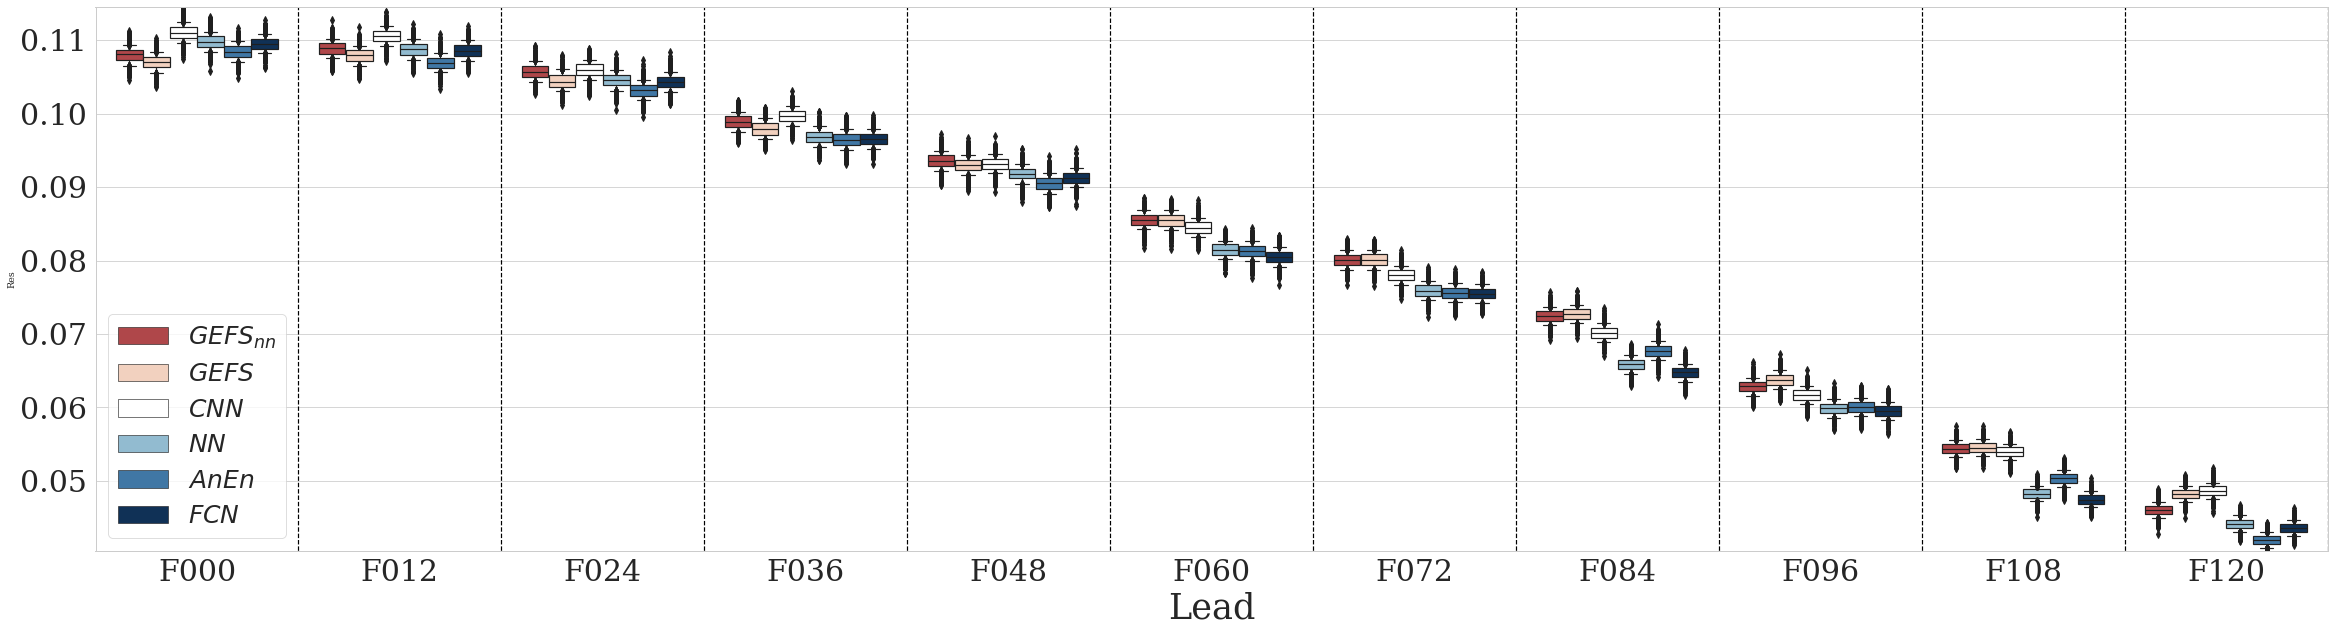

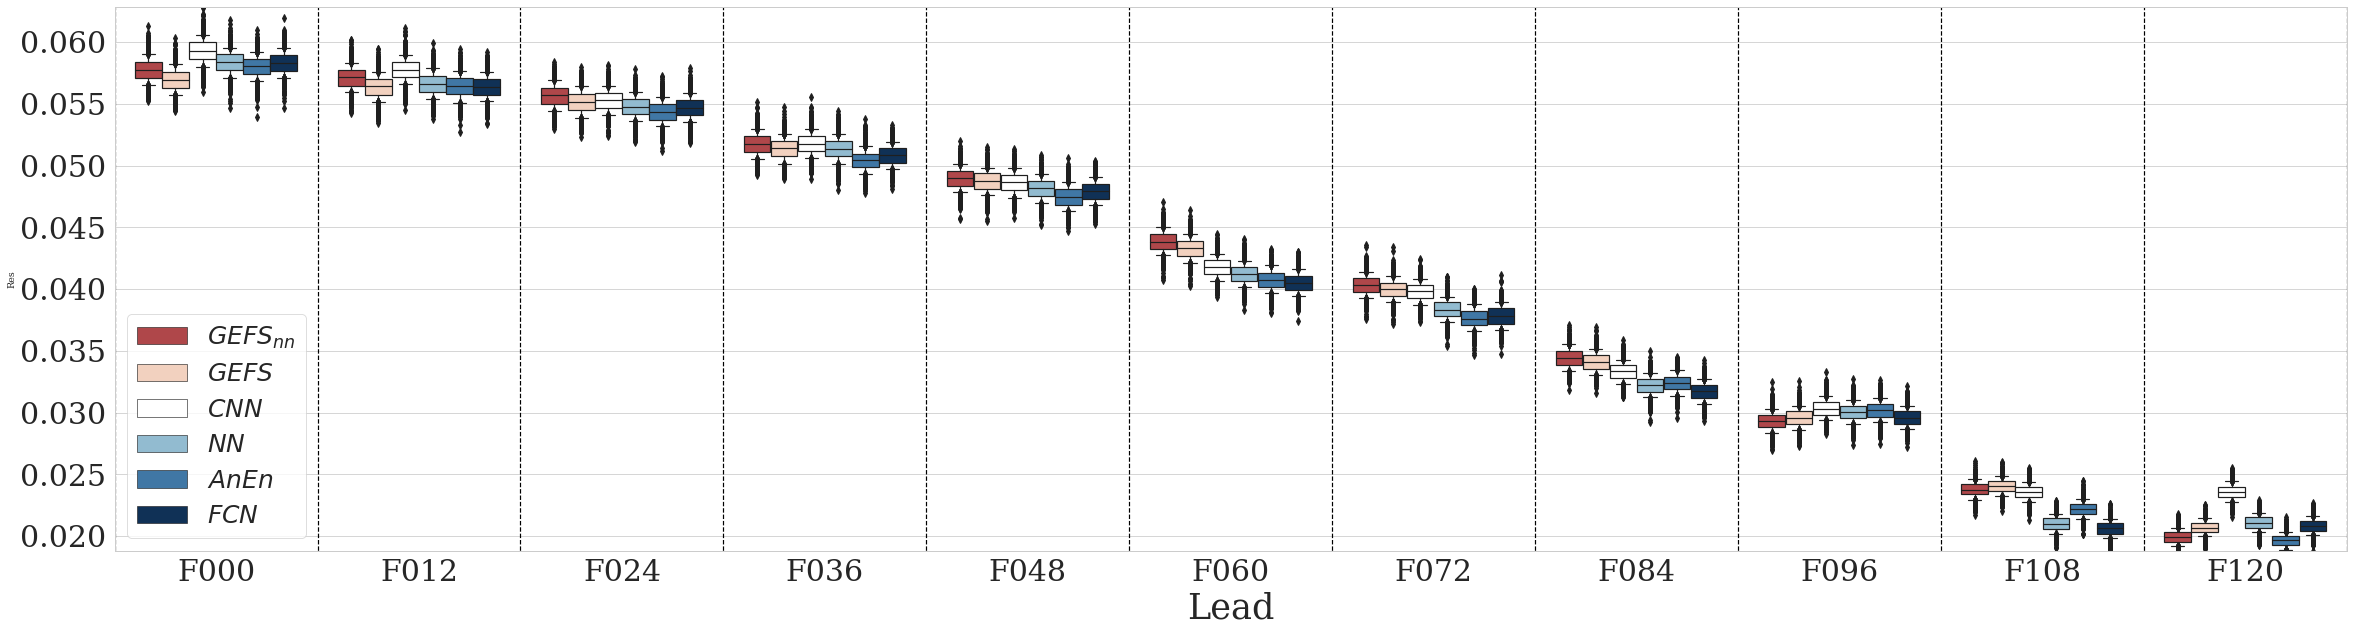

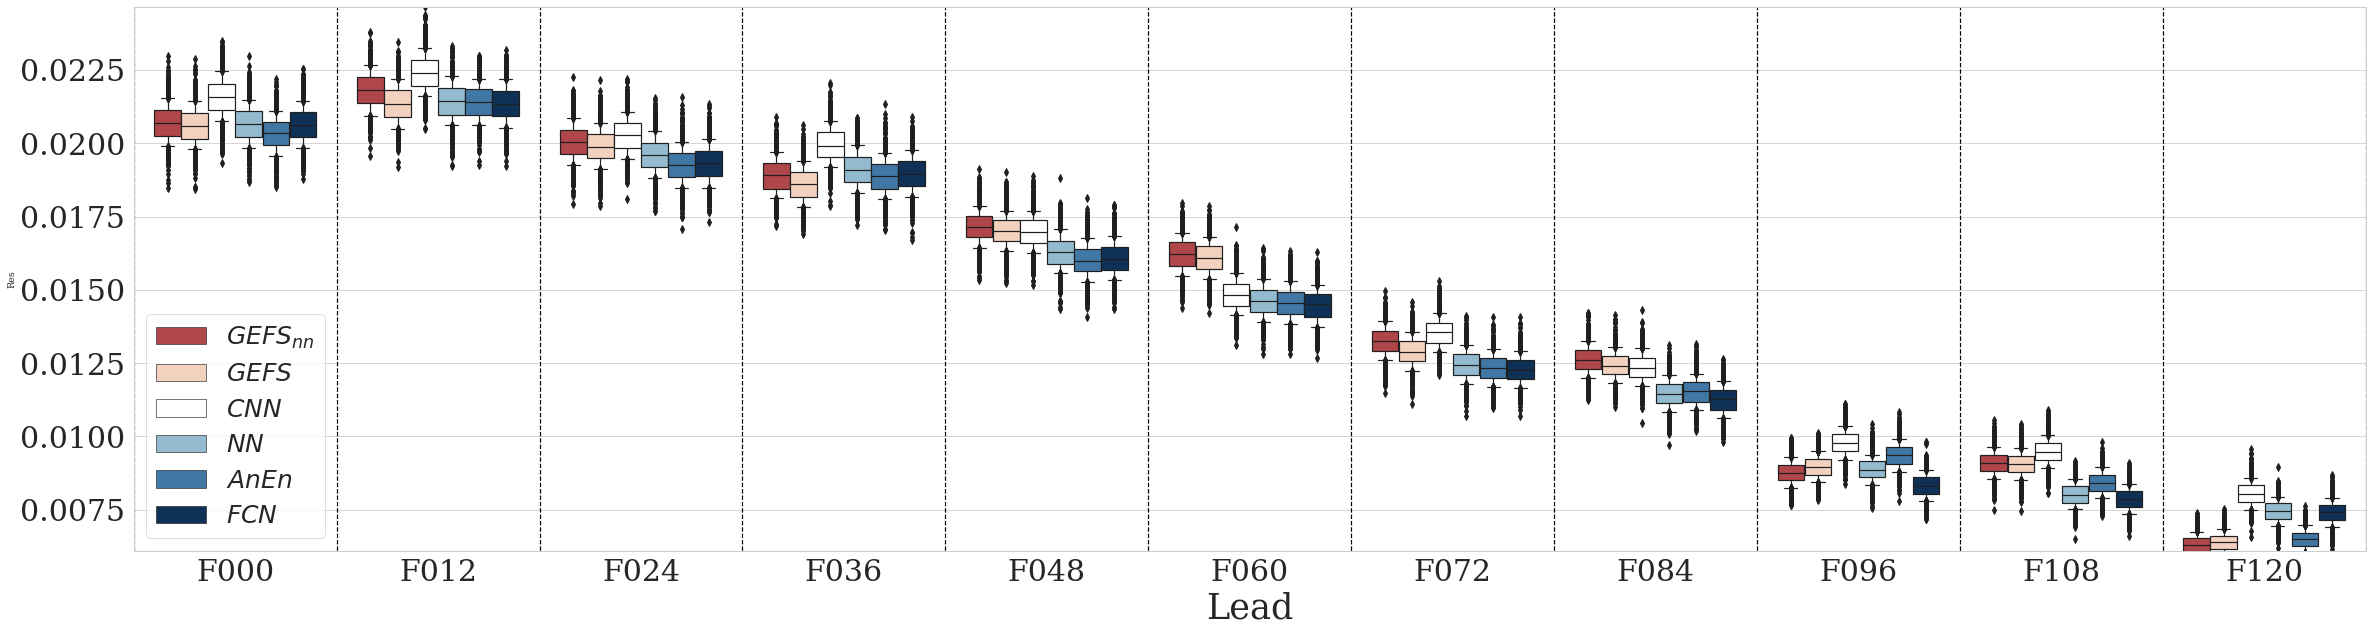

In [4]:

for percy in [250,350,500]:
    fn = '/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/DataFrames/Brier_FCN_threshold_'+str(percy)+'.pkl'

    dffin = pd.read_pickle(fn)

    plt.figure(figsize=BPdict['FigSize'])
    plt.plot([-10,23],[0,0],'k')

    ax = sns.boxplot(x="Lead", y="Res", hue="Model",data=dffin, palette=mycolors,whis=[10, 90])
    plt.yticks(fontsize=BPdict['tickFS'])
    plt.xticks(fontsize=BPdict['tickFS'])
    # plt.ylabel('[%]',fontsize=BPdict['labelFS'])
    plt.xlabel('Lead',fontsize=BPdict['labelFS'])
    plt.legend(fontsize=BPdict['legendFS'],loc='lower left')
    # plt.title('Resolution',fontsize=BPdict['titleFS'])

    for bb in np.arange(-0.5,22,1):
        plt.plot([bb,bb],[-25,25],'k--')

    plt.ylim([np.min(dffin['Res']+.001),np.max(dffin['Res'])])
    plt.xlim([-0.5,10.5])

    plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Resolution_threshold_'+str(percy)+'.png',dpi = 300,bbox_inches='tight')
    plt.show()

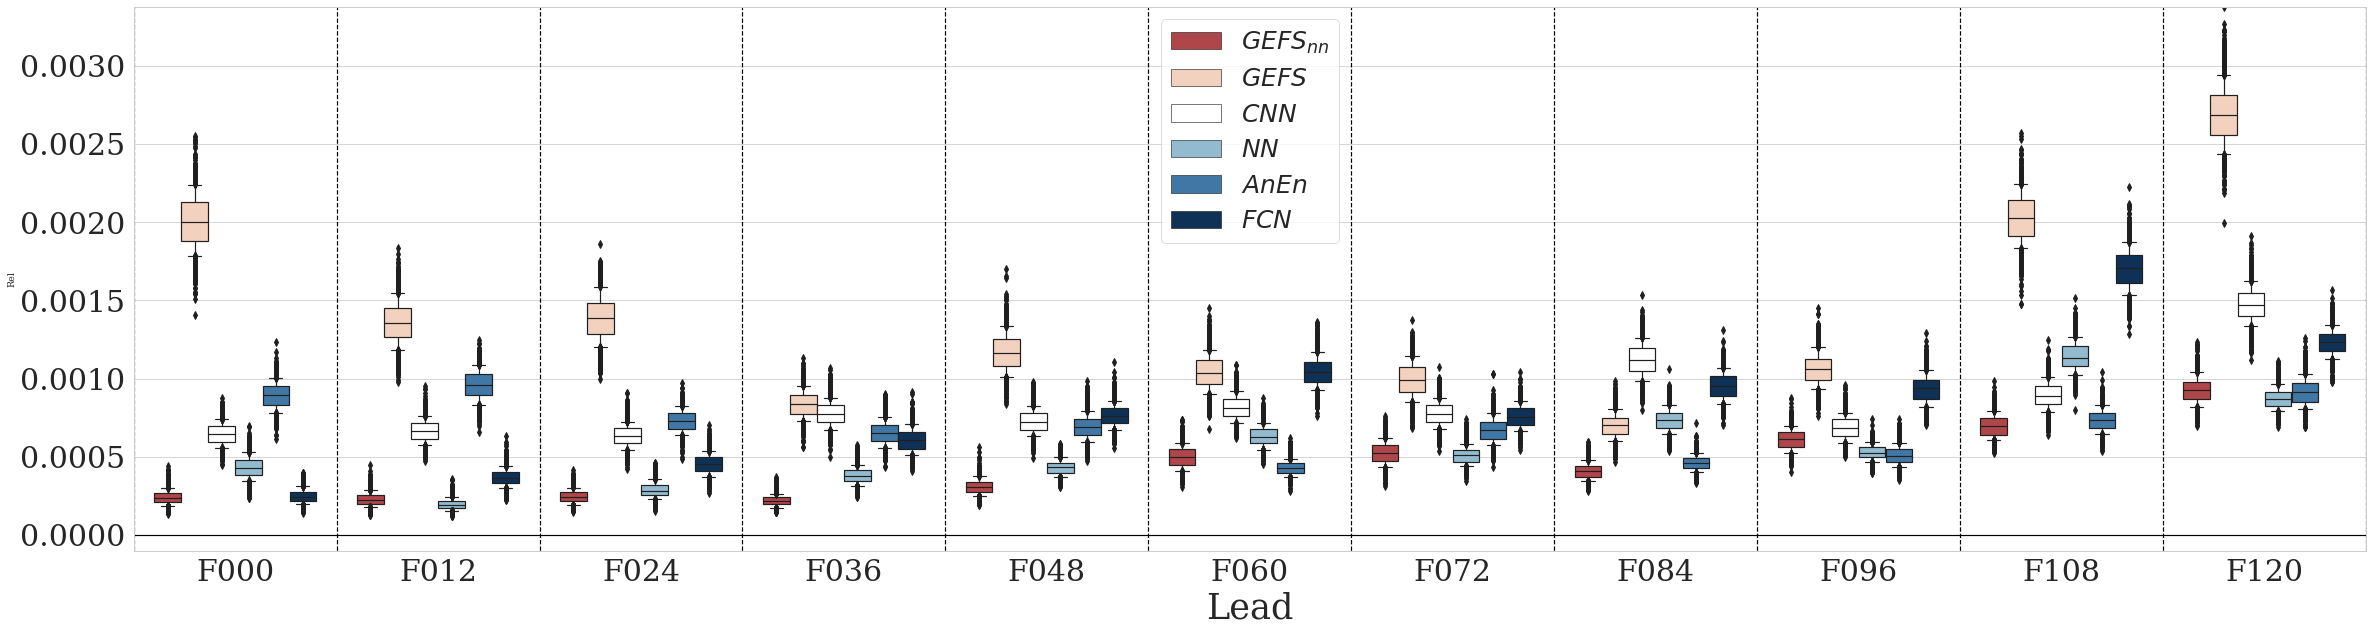

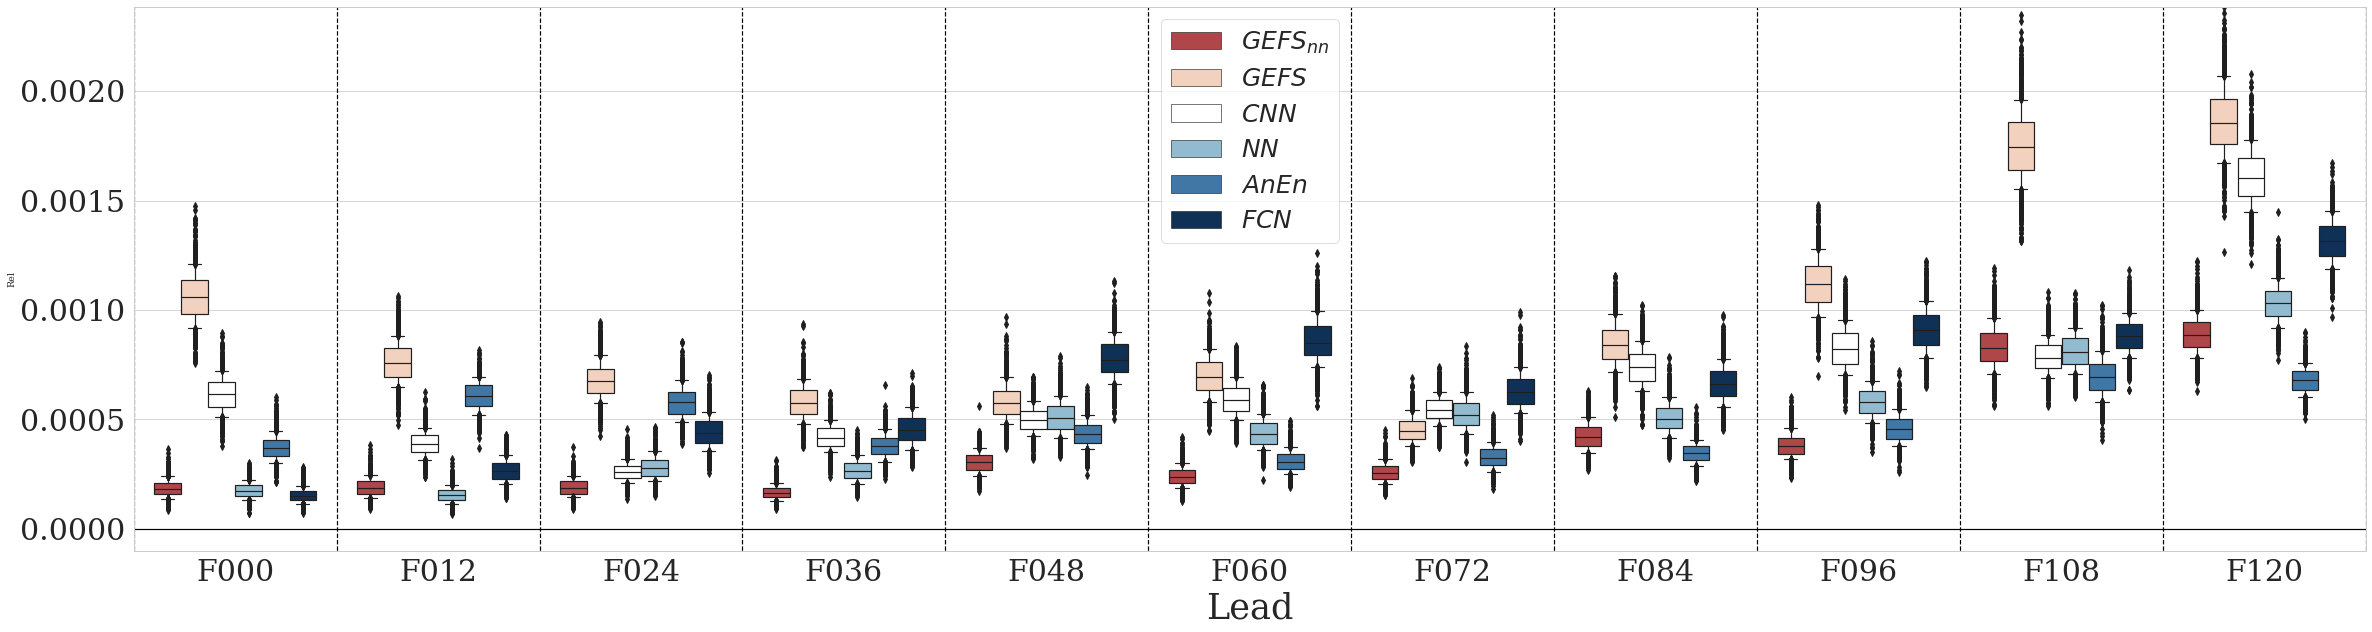

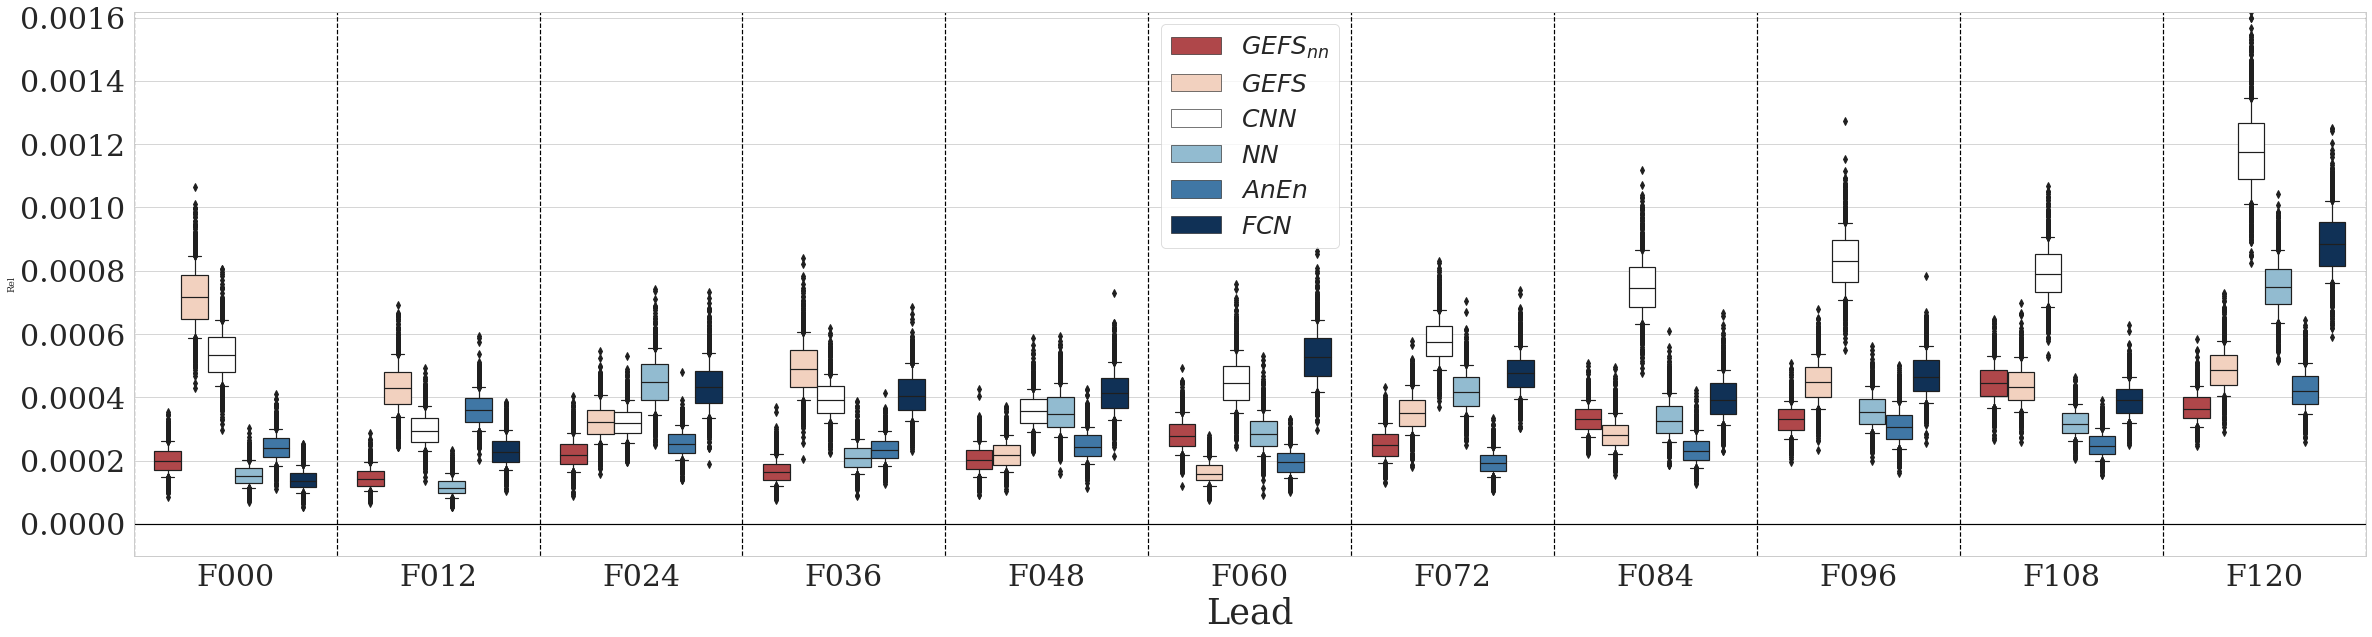

In [4]:
for percy in [250,350,500]:
    fn = '/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/DataFrames/Brier_FCN_threshold_'+str(percy)+'.pkl'

    dffin = pd.read_pickle(fn)

    plt.figure(figsize=BPdict['FigSize'])
    plt.plot([-10,23],[0,0],'k')

    ax = sns.boxplot(x="Lead", y="Rel", hue="Model",data=dffin, palette=mycolors,whis=[10, 90])
    plt.yticks(fontsize=BPdict['tickFS'])
    plt.xticks(fontsize=BPdict['tickFS'])
    # plt.ylabel('[%]',fontsize=BPdict['labelFS'])
    plt.xlabel('Lead',fontsize=BPdict['labelFS'])
    plt.legend(fontsize=BPdict['legendFS'],loc='best')
    # plt.title('Reliability',fontsize=BPdict['titleFS'])

    for bb in np.arange(-0.5,22,1):
        plt.plot([bb,bb],[-25,25],'k--')

    plt.ylim([-.0001,np.max(dffin['Rel'])])
    plt.xlim([-0.5,10.5])
    plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_threshold_'+str(percy)+'.png',dpi = 300,bbox_inches='tight')

    plt.show()